In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from EnvLibs import Environment, RewardKernel, TrafficGenerator

In [2]:
def PolicyDemoFixed(u, params):
    alpha = 0.2
    w = typeAllocator(u, params['LEN_window'])
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    M = 3
    return w, r, M, alpha

def PolicyDemoAdaptiveAlpha(u, params): 
    rewardKernel = RewardKernel(params)
    w = typeAllocator(u, params['LEN_window'])
    M = 3 
    alphaList = np.linspace(0.01, 1.0, 100)
    JmdpRecord = []
    for alpha in alphaList:
        r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w 
        Jmdp = rewardKernel.getReward(u, w, r, M, alpha)
        JmdpRecord.append(Jmdp)
    alpha = alphaList[np.argmin(JmdpRecord)]
    r = np.floor(alpha*params['B'])/(np.sum(w)+1e-10) * w
    return w, r, M, alpha

def typeAllocator(u, lEN_window):
    w = (u>int(lEN_window*0.5)).astype(int)
    return w

In [3]:
def runSimulation(policy, params, trafficGenerator, num_epochs=1000):
    """
    Run simulation with a given policy function
    
    Args:
        policy_func: Function that takes (u, params) and returns (w, r, M, alpha) as action
        params: Dictionary of parameters
        num_epochs: Number of simulation epochs (default: 1000)
    
    Returns:
        rewardRecord: List of rewards for each epoch
    """
    env = Environment(params, trafficGenerator)
    rewardRecord = []
    alphaRecord = []
    for epoch in range(num_epochs):
        #u = env.updateStates()
        u = env.trafficGenerator.updateReadTraffic()
        (w, r, M, alpha) = policy(u, params)
        reward = env.applyActions(np.array(w), np.array(r), M, alpha)
        rewardRecord.append(reward)
        alphaRecord.append(alpha)
    
    return rewardRecord, alphaRecord, env

avgPacketLossRate_fixed: 0.05780121070103383, avgPacketLossRate_adaptive: 0.03293465071936154


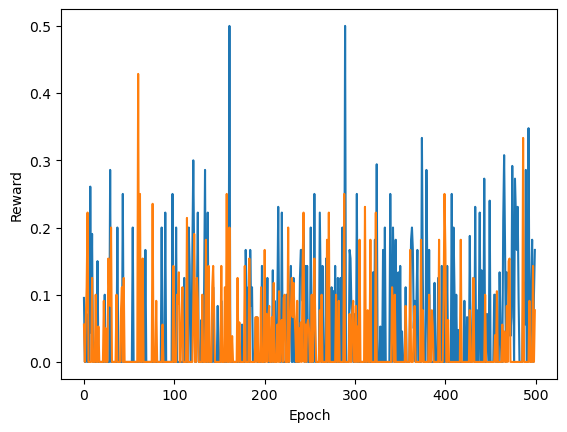

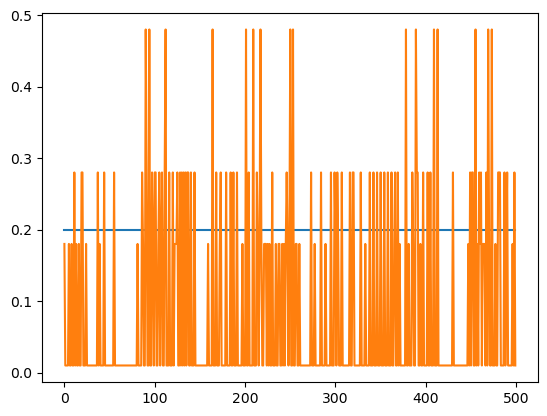

In [4]:
params = {
    'N_user': 4,
    'LEN_window': 10,
    'r_bar': 4,
    'B': 40,
    'randomSeed': 999,
}

with open('Results/TrafficData/trafficData.pkl', 'rb') as f:
    trafficData = pickle.load(f)

trafficGenerator = TrafficGenerator(params)
trafficGenerator.registerDataset(trafficData['traffic'])
# Example usage:
rewardRecord_fixed, alphaRecord_fixed, env_fixed = runSimulation(PolicyDemoFixed, params, trafficGenerator, num_epochs=500)
rewardRecord_adaptive, alphaRecord_adaptive, env_adaptive = runSimulation(PolicyDemoAdaptiveAlpha, params, trafficGenerator, num_epochs=500)
avgPacketLossRate_fixed = env_fixed.getPacketLossRate()
avgPacketLossRate_adaptive = env_adaptive.getPacketLossRate()
print(f"avgPacketLossRate_fixed: {avgPacketLossRate_fixed}, avgPacketLossRate_adaptive: {avgPacketLossRate_adaptive}")

plt.plot(rewardRecord_fixed)
plt.plot(rewardRecord_adaptive)
plt.xlabel("Epoch")
plt.ylabel("Reward")
plt.show()
plt.plot(alphaRecord_fixed)
plt.plot(alphaRecord_adaptive)     
plt.show()